### Notebook 02: EDA

In [11]:
# Import neccessary support
import pandas as pd
import numpy as np
import cv2, os
import random

import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from zipfile import ZipFile

#import matplotlib.image as mpimg
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing import image

# load VGG-16 model: 23 layers, 138,357,544 params, 528MB
from keras.applications.vgg16 import VGG16
# These models expect 
from tensorflow.keras.applications.vgg16 import preprocess_input, decode_predictions
from keras.utils.vis_utils import plot_model

#from sklearn.preprocessing import LabelBinarizer
#from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.layers import GlobalAveragePooling2D

In [12]:
# Load Image ID's from text file
with open('../data/dog_data_part2.txt', 'r') as imagehandles:
    # Store Image ID's as variable for image pre-processing, removing the endline character in the process
    dog_data_part2 = [image_id[:-1] for image_id in imagehandles]
    
    # Store dog_data_part2 with IPython MAGIC Methods
    %store dog_data_part2
    
# Check that all is copacetic
len(dog_data_part2), type(dog_data_part2), dog_data_part2[0], type(dog_data_part2[0])

(1240, list, '2377385', str)

In [13]:
import tensorflow as tf
print(tf.__version__)

2.3.1


2.3.1
Please install GPU version of TF


In [15]:
import tensorflow as tf
print(tf.__version__)
# Sometimes my tensorflow tries to use GPU support but I don't want it to, have had many errors.
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
import tensorflow as tf
#tf.compat.v1.Session(), .compat.v1.
sess_cpu = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(device_count={'GPU': 0}))
print(tf.__version__)
if tf.test.gpu_device_name():
    print('Default GPU Device:{}'.format(tf.test.gpu_device_name()))
else:
    print("Please install GPU version of TF")

if tf.test.gpu_device_name():
    print('Default GPU Device:{}'.format(tf.test.gpu_device_name()))
else:
    print("Please install GPU version of TF")

Please install GPU version of TF


### Instantiate VGG-16 Model<br>
>  Image data format: Set in Keras JSON config file<br>
> - Stored at  '~/.keras/keras.json'<br>
{<br>
    "floatx": "float32",<br>
    "epsilon": 1e-07,<br>
    "backend": "tensorflow",<br>
    "image_data_format": "channels_last"<br>
}<br><br>
- NOTE: "Channels Last = (height, width, depth)-TensorFlow data format convention<br>

#### Vizualize filters and feature maps of CNNs with VGG-16

In [16]:
# load VGG-16 model: 23 layers, 138,357,544 params, 528MB

# Adjust input size of the model for include_top=False
# new_input = Input(shape=(224,224,3)) --> MUST INCLUDE THIS PARAM AFTER CLASSIFICATION

# load the model weights into memory
# https://keras.io/api/applications/vgg/#vgg16-function
model_vgg16 = VGG16(weights='imagenet')
#model_vgg16 = VGG16(
#                include_top=True,   # include_top=False to load model wihtout the fully-connected output layers used to make predictions
#                weights='imagenet', # Weights are downloaded automatically when instantiating a model: Keras Applications ~/.keras/models/
#                input_tensor=None,  # input_tensor = new_input = Input(shape=(224,224,3))
#                input_shape=None,
#                pooling=None,
#                classes=1000,
#                classifier_activation="softmax"
#            )
# Summarize the loaded model with all layers (include_top=True)
model_vgg16.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

#### Filter Summary (by network layer)

In [17]:
# VGG-16 Layers with non-zero parameters
layers_VGG16 = [ 1, 2, 4, 5, 7, 8, 9, 11, 12, 13, 15, 16, 17, 20, 21, 22 ]
# Choose a layer to perform feature extraction
layer_VGG16  = 0
# summarize filter shapes
print('Layer Summary\tKernel Size: ( K x K )\t')
print()
print('Number\t\tName\t\t(K, K, Depth, Nodes)')
# Loop thru each layer in ImageNet Model to summarize
for layer in model_vgg16.layers:
    # check for convolutional layer
    if ('conv' not in layer.name) & ('fc' not in layer.name):
        layer_VGG16 += 1
        continue # Exclude fully connected layers & return to loop beginning
    # get filter weights
    filters, biases = layer.get_weights()
    print(f'Layer {layer_VGG16}:\t{layer.name}\t{filters.shape}')
    layer_VGG16 += 1
print()

# Select layer from VGG-16 layers list above to retrieve weights
layer_number = layers_VGG16[0]
# Retrieve current weights from selected hidden layer: 'layer_number'
# Weights rep state of layer, get_weights loads state into similarly parameterized layers
filters_extract, biases_extract = model_vgg16.layers[layer_number].get_weights()
print(f'Layer {layer_number}: {filters_extract.shape}')

Layer Summary	Kernel Size: ( K x K )	

Number		Name		(K, K, Depth, Nodes)
Layer 1:	block1_conv1	(3, 3, 3, 64)
Layer 2:	block1_conv2	(3, 3, 64, 64)
Layer 4:	block2_conv1	(3, 3, 64, 128)
Layer 5:	block2_conv2	(3, 3, 128, 128)
Layer 7:	block3_conv1	(3, 3, 128, 256)
Layer 8:	block3_conv2	(3, 3, 256, 256)
Layer 9:	block3_conv3	(3, 3, 256, 256)
Layer 11:	block4_conv1	(3, 3, 256, 512)
Layer 12:	block4_conv2	(3, 3, 512, 512)
Layer 13:	block4_conv3	(3, 3, 512, 512)
Layer 15:	block5_conv1	(3, 3, 512, 512)
Layer 16:	block5_conv2	(3, 3, 512, 512)
Layer 17:	block5_conv3	(3, 3, 512, 512)
Layer 20:	fc1	(25088, 4096)
Layer 21:	fc2	(4096, 4096)

Layer 1: (3, 3, 3, 64)


In [18]:
filters_extract[0][0][0]

array([ 0.42947057,  0.11727387,  0.03401296,  0.35422093, -0.0865837 ,
        0.22968295,  0.06683242,  0.04133838,  0.13026784,  0.03291035,
        0.09615457, -0.09222532, -0.15587331,  0.0522968 , -0.08324417,
        0.15728769,  0.0291196 ,  0.05094835,  0.19055748, -0.04372229,
        0.3618031 ,  0.23902874,  0.16667192, -0.18046746,  0.04404821,
        0.09592837, -0.04381131, -0.1884835 , -0.04399502, -0.18985446,
       -0.23386982,  0.12836744, -0.11059975,  0.00571336, -0.24479656,
       -0.30530283,  0.060938  , -0.32816252,  0.1711953 ,  0.10265407,
       -0.11063665,  0.33012986, -0.05869728,  0.18478717,  0.01050853,
        0.10668027, -0.13086924, -0.36283946,  0.06440807,  0.09335972,
        0.00401619,  0.37814805,  0.05268804, -0.27078936,  0.11060741,
       -0.11819526,  0.04298935,  0.35323623, -0.28468162, -0.20289008,
       -0.284944  , -0.13224158, -0.05334752,  0.00757738], dtype=float32)

In [19]:
# (kernel-height, kernel-width, channel-depth, No. of filters)
# 64-filters each (3 x 3 x 3) 3D volume, cubic filters
filters_extract.shape, type(filters_extract)

((3, 3, 3, 64), numpy.ndarray)

In [20]:
filters_extract[0][0].shape

(3, 64)

In [21]:
filters_extract.min(3)

array([[[-0.36283946, -0.48702785, -0.45139903],
        [-0.39102998, -0.495031  , -0.46935585],
        [-0.3776668 , -0.50566256, -0.4622438 ]],

       [[-0.37709406, -0.4805826 , -0.44129026],
        [-0.43290257, -0.46505883, -0.43076617],
        [-0.51870257, -0.67140007, -0.6122331 ]],

       [[-0.38299575, -0.48918396, -0.45314637],
        [-0.40317345, -0.5517545 , -0.46822482],
        [-0.38670486, -0.5010919 , -0.45361367]]], dtype=float32)

In [22]:
 filters_extract.max(3)

array([[[0.42947057, 0.55037946, 0.4800154 ],
        [0.50021327, 0.6085159 , 0.5649865 ],
        [0.42510888, 0.57510966, 0.51294214]],

       [[0.36549452, 0.43711686, 0.40405855],
        [0.48986775, 0.52829504, 0.5055312 ],
        [0.44455817, 0.5295403 , 0.4862477 ]],

       [[0.32685903, 0.4086302 , 0.37457848],
        [0.459542  , 0.53946865, 0.5184412 ],
        [0.40483335, 0.454858  , 0.40707463]]], dtype=float32)

#### Visualize Second Layer (First Conv2D Layer immediately following the input layer)

	Layer 1:  FILTER #


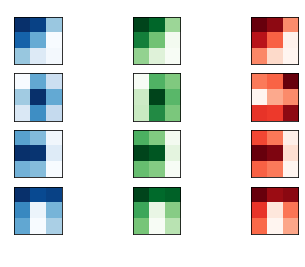

In [23]:
# normalize filter values to 0-1 so we can visualize them
f_min, f_max = filters_extract.min(), filters_extract.max()
# Sets the minimum to zero and the maximum to one
filters_extract = (filters_extract - f_min) / (f_max - f_min)

# plot first few filters
n_filters, ix = 4, 1
for i in range(n_filters):
    # get the filter
    f = filters_extract[:, :, :, i]
    # plot each channel separately
    for j in range(3):
        # specify subplot and turn of axis
        if j == 0:
            c = '\nBLUE'
            color_map = 'Blues'
        elif j == 1:
            c = '\nGREEN'
            color_map = 'Greens'
        else:
            c ='\nRED'
            color_map = 'Reds'
        ax = plt.subplot(n_filters, 3, ix, fc='grey')
        ax.set_xticks([])
        ax.set_yticks([])
        plt.xlabel(xlabel=c,color='w')
        plt.ylabel(ylabel=f'  \n\n{i+1}',color='w',rotation=0)
        # plot filter channel in grayscale
        plt.imshow(f[:, :, j], cmap=color_map)
        ix += 1
#print('\t\t FILTER #')
print(f'\tLayer {layer_number}:  FILTER #')

#### Test Visual Genome Dog Data, chosen at random, on VGG-16 Loaded Weights

In [24]:
%%time

# NOTICE, SOME CODE IN THIS CELL FROM:
# https://thispointer.com/python-how-to-get-the-list-of-all-files-in-a-zip-archive/

# Input shape acrandom_dogby VGG-16 = 224 x 224 x3
img_height = 224
img_width = 224

# Choose a dog randomly to test breed accuracy
dog_pic_x = random.randint(0, len(dog_data_part2)-1)
random_dog = int(dog_data_part2[dog_pic_x])

# ~5.5 GB ZIP Archive, 40% of total data set
# Open, read, and close ZIP file for faster image pre-processing
with ZipFile('../../visual_genome_part2.zip', "r") as z:
    # One file in zip archive
    VG_100K_2 = z.namelist()

    # Iterate over image file names, 'VG_100K_2/image_id.jpg'
    for ith_image in VG_100K_2: 
        # Get extension of file, '.jpg'
        ext = os.path.splitext(ith_image)[-1]
        # Get root of file, root = VG_100K_2/image_id.jpg
        root = os.path.splitext(ith_image)[0]
        
        # Skip over Archive Directory
        if (ext == ".jpg"):
            
            # Skip root[:10]='VG_100K_2' in dog_pic_ids
            if int(root[10:]) == random_dog:
                
                # Read image binary data of 'VG_100K_2' from zip archive('visual_genome_part2.zip')
                in_bytes = z.read(ith_image) # VG_100K_2/
                # Decode bytes to image
                img = cv2.imdecode(np.frombuffer(in_bytes, np.uint8), cv2.IMREAD_COLOR)
                
                # Input shape accepted by VGG-16 = 224 x 224 x3
                img_input = cv2.resize(img, dsize=(img_width, img_height))
                
                # Convert a PIL image instance to a Numpy array
                dog_x = image.img_to_array(img_input)
                #img_display = image.img_to_array(img)
                
                # Expand the shape of the array: Insert new axis at 'axis' position in expanded array shape
                dog_x = np.expand_dims(dog_x, axis=0)
                #img_display = np.expand_dims(img_display, axis=0)
                
                # Returns array with type: 'float32', covert: RGB --> BGR, & zero-center each channel wrt ImageNet dataset
                # i.e. subtract mean RGB value, computed on Train set, from each pixel
                dog_x = preprocess_input(dog_x)
                #img_display = preprocess_input(img_display)
                
                # Extract features from image_id = dog_x with VGG-16
                # Get a prediction: Probability dog_x image belongs to each of the 1,000 object types from ImageNet
                preds = model_vgg16.predict(dog_x)

                # Decode extracted features into class, description, and probability
                # Converts probabilities to class labels
                preds_class_breed_score = decode_predictions(preds, top=5)[0]
                
                # Display the prediction corresponding to the image
                print(f'Prediction: (for random dog = {random_dog}) \n')
                for i in range(len(preds_class_breed_score)):
                    print(f'\t{preds_class_breed_score[i][2]*100:.2f}%\t:{preds_class_breed_score[i][1]}')

                # Output img with window name as 'image' 
                cv2.imshow('img', img)
                
                # Display for 30 secs = 1_000ms * 30
                #cv2.waitKey(30*1000)
                # Display image indefinitely
                cv2.waitKey(0)

cv2.destroyAllWindows()

Prediction: (for random dog = 2393695) 

	23.36%	:bison
	12.62%	:cock
	12.13%	:ox
	7.36%	:kelpie
	5.32%	:ram


### List of dogless images mixed into the dog dataset

In [25]:
misplaced_images = [2394890]

In [26]:
img_path = '../../visual_genome_part2/VG_100K_2/2405343.jpg'
img = image.load_img(img_path, target_size=(224, 224))
dog_x = image.img_to_array(img)
dog_x = np.expand_dims(dog_x, axis=0)
dog_x = preprocess_input(dog_x)

# Extract features from image_id = dog_x with VGG-16
# Get a prediction: Probability dog_x image belongs to each of the 1,000 object types from ImageNet
preds = model_vgg16.predict(dog_x)

# Decode extracted features into class, description, and probability
# Specifically, converts probabilities to class labels
preds_class_breed_score = decode_predictions(preds, top=5)[0] # top = n returns top-n most likely classes for given image
print('Prediction: \n')
for i in range(len(preds_class_breed_score)):
    print(f'\t{preds_class_breed_score[i][2]*100:.2f}%\t:{preds_class_breed_score[i][1]}')

Prediction: 

	37.11%	:keeshond
	13.47%	:schipperke
	8.45%	:Newfoundland
	7.30%	:groenendael
	6.35%	:Norwegian_elkhound


In [27]:
type(preds), len(preds)

(numpy.ndarray, 1)

In [28]:
# Creates an unneccessary plot of VGG-16 Model Layers, will install and check-out if there's time
plot_model(model_vgg16, to_file='../images/vgg16.png')

('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')


In [29]:
# Path to Training data
BASEPATH1 = '../../visual_genome_part1/VG_100K_1/'
# Path to Validation data
BASEPATH2 = '../../visual_genome_part2/VG_100K_2/'

# Images in Train set: Part 1 
LABELS1 = set() # {set of integers of image_ids }
paths1 = [] # [List of tuples ('string of full image path + file name', 'image_id')...(64_344 out of 108_077 tuples/images) ]

# Images in Validation set: Part 2 {set of integers of image_ids }
LABELS2 = set() # {set of integers of image_ids }
paths2 = [] # [List of tuples ('string of full image path + file name', 'image_id')...(43_733 out of 108_077 tuples/images) ]

# For the Validation Data
print('Output from first three iterations:\n')
check = 0

for d in os.listdir(BASEPATH2):
    LABELS2.add(int(d[:-4]))
    if d[:-4] not in dog_data_part2:
        paths2.append((BASEPATH2+d, d[:-4], 0))
    elif d[:-4] in dog_data_part2:
        paths2.append((BASEPATH2+d, d[:-4], 1))   
    if check < 3:
        print('d =', d)
        print('Validation LABELS: ', LABELS2)
        print('Validation paths: ', paths2)
        print()
        check += 1

Output from first three iterations:

d = 1.jpg
Validation LABELS:  {1}
Validation paths:  [('../../visual_genome_part2/VG_100K_2/1.jpg', '1', 0)]

d = 100.jpg
Validation LABELS:  {1, 100}
Validation paths:  [('../../visual_genome_part2/VG_100K_2/1.jpg', '1', 0), ('../../visual_genome_part2/VG_100K_2/100.jpg', '100', 0)]

d = 1000.jpg
Validation LABELS:  {1000, 1, 100}
Validation paths:  [('../../visual_genome_part2/VG_100K_2/1.jpg', '1', 0), ('../../visual_genome_part2/VG_100K_2/100.jpg', '100', 0), ('../../visual_genome_part2/VG_100K_2/1000.jpg', '1000', 0)]



In [30]:
# Check that all is copacetic with the Validation set labeling above
count_dog_p2 = 0
count_dogless_p2 = 0
print('Output from first three iterations:\n')
check = 0
for path, image_id, tag_label in paths2: # dtypes = ('str', 'str', int)
    if tag_label == 1:
        count_dog_p2 += 1
    elif tag_label == 0:
        count_dogless_p2 += 1
    if check < 1:
        print('path: ', path)
        print('image_id: ', image_id)
        print('tag_label: ', tag_label)
        print()
        check += 1
print(f'Properly Labeled Dog Pics (out of 1240): {count_dog_p2}\nProperly Labeled Dogless Pics (out of 42,493):  {count_dogless_p2}')

Output from first three iterations:

path:  ../../visual_genome_part2/VG_100K_2/1.jpg
image_id:  1
tag_label:  0

Properly Labeled Dog Pics (out of 1240): 1240
Properly Labeled Dogless Pics (out of 42,493):  42493


#### Function to prepare data for input to VGG-16 Network:

In [31]:
# resizing and converting to RGB
def load_and_preprocess_image(path):
    image = cv2.imread(path)
    image = cv2.resize(image, (224,224))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image

#### The code in the cell below will first check for an existing X_valid array of processed data stored in .txt files
> * If the try results in a FinalNotFoundError, X-images and y-labels arrays will be created

In [137]:
%%time
# Load target labels for validation data set
try:
    with open('../../assets/y_validation_labels.txt', 'r') as validlabels:
        # Store validation images as variable for loading into model for scoring
        y_valid_loaded = np.array([valid_image_label for valid_image_label in validlabels])

    # Load feature matrix of Validation images from text file
    with open('../../assets/X_validation_image_data.txt', 'r') as validimages:
        # Store validation images as variable for loading into model for scoring
        X_valid_loaded = np.array([processed_image for processed_image in validimages])

    # Check that all is copacetic
    len(X_valid), type(dog_data_part2), dog_data_part2[0], type(dog_data_part2[0])
    print('Final No. of Dog labels in validation set: ', count_dogs) # No. of target labels/tags equal to one
    print('Final Length X_valid: ', len(X_valid)) # Length of list of images
# Just in case the data can be loaded from text, we want to know!
except FileNotFoundError:
    print('HEADS UP: Could not load validation images/labels from .txt files...\n\
                \t...hold on for ~10-15 mins while X and y are prepared')
    print()
    # Build a feature matrix 
    X_valid = []
    y_valid = []
    check = 0
    count_dogs = 0
    # Recall that paths1 and paths2 have 3-tuple info for each image in dataset
    for  path, image_id, tag_label in paths2:  # dtypes = ('str', 'str', int)
        #for image_path in os.listdir(path):
        image = load_and_preprocess_image(path)
         # X[image_index] image corresponds to image_id = paths2[image_index][1]
        X_valid.append(image)
        # y[image_index] label corresponds to image_id = paths2[image_index][1]
        y_valid.append(tag_label) 
        # Just a simple counter of the number of ones to cofirm with known number of dog images
        if tag_label == 1:
            count_dogs += 1
        check += 1
        # Only display load status a few times throughout the entire pre-process
        if check % 10000 == 0:
            print('path: ', path)
            print('image_id: ', image_id)
            print('No. of Dog labels so far: ', count_dogs) # No. of target labels/tags equal to one
            print('Length X_valid: ', len(X_valid)) # Length of list of images
            print()
    # Display final outcome of pre-processing
    print('Total No. of Dog labels: ', count_dogs) # No. of target labels/tags equal to one
    print('Final Length X_valid: ', len(X_valid)) # Length of list of images
    # Save X_valid and y_valid arrays as txt files in assets folder (just outside of Github repo) to load in Notebook 3
    with open('../../assets/X_validation_image_data.txt', 'w') as validimages:
        validimages.writelines("%s\n" % img for img in X_valid)
    with open('../../assets/y_validation_labels.txt', 'w') as validimages:
        validimages.writelines("%s\n" % img for img in y_valid)

HEADS UP: Could not load validation images/labels from .txt files...
                	...hold on for ~10-15 mins while X and y are prepared

path:  ../../visual_genome_part2/VG_100K_2/2386282.jpg
image_id:  2386282
No. of Dog labels so far:  285
Length X_valid:  10000

path:  ../../visual_genome_part2/VG_100K_2/2396739.jpg
image_id:  2396739
No. of Dog labels so far:  602
Length X_valid:  20000

path:  ../../visual_genome_part2/VG_100K_2/2407172.jpg
image_id:  2407172
No. of Dog labels so far:  908
Length X_valid:  30000

path:  ../../visual_genome_part2/VG_100K_2/2417632.jpg
image_id:  2417632
No. of Dog labels so far:  1203
Length X_valid:  40000

Total No. of Dog labels:  1240
Final Length X_valid:  43733
Wall time: 14min 39s


X_valid:
	Length: 43733
        DType: <class 'list'>
        Element Shapes: (224, 224, 3)
        Element DTypes: <class 'numpy.ndarray'>



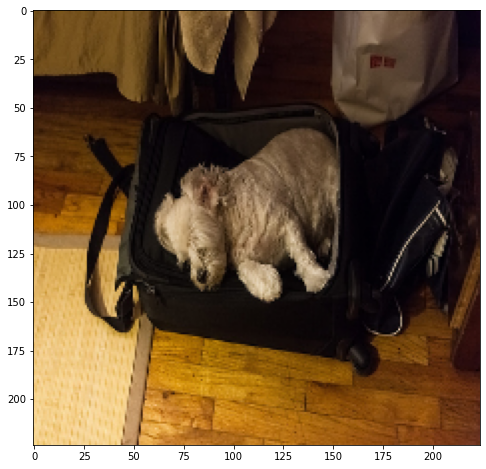

In [117]:
# Check that all is copacetic
print('X_valid:')
print(f'\tLength: {len(X_valid)}\n\
        DType: {type(X_valid)}\n\
        Element Shapes: {X_valid[0].shape}\n\
        Element DTypes: {type(X_valid[0])}\n')

# Show pic
plt.figure(figsize = (8, 8)); 
plt.imshow(X_valid[2766], aspect='auto');

In [ ]:
#encoder = LabelBinarizer()
#X = np.array(X_valid)
#y = encoder.fit_transform

### model.save('/../assets/model.h5')

print("Saved model to disk")
#del model

In [141]:
# I am running out of time and while I can save and load this variable to a file I am unsure how to preserve shape and format
%store X_valid

Stored 'X_valid' (list)


In [142]:
len(X_valid)

43733

In [145]:
X_valid[0].shape

(224, 224, 3)

In [146]:
%store y_valid

Stored 'y_valid' (list)
